In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cvx_portfolio.costs import TcostModel
from cvx_portfolio.returns import MarketReturns
from cvx_portfolio.simulator import MarketSimulator
from cvx_portfolio.policies import Hold,PeriodicRebalance

plotdir = '../portfolio/plots/'
datadir= '../equity_data_tool/'

## Download data using ee103 code (to be integrated) 

In [2]:
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])
prices=pd.read_csv(datadir+'prices.txt',index_col=0,parse_dates=[0])

## Market simulator 

In [3]:
del volumes['USDOLLAR']
del sigmas['USDOLLAR']

spread = pd.DataFrame(data=5e-4, index=volumes.index, columns=volumes.columns)
nonlin_coeff = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns)

simulated_tcost = TcostModel(volumes, sigmas, spread, nonlin_coeff, cash_key='USDOLLAR')

simulator = MarketSimulator(MarketReturns(returns), volumes, [simulated_tcost], cash_key='USDOLLAR')

In [3]:
# a = pd.DataFrame(data=5e-4, index=returns.index, columns=returns.columns)
# b = pd.DataFrame(data=1, index=returns.index, columns=returns.columns)
# s = pd.DataFrame(data=0, index=returns.index, columns=returns.columns)

# simulated_tcost = TcostModel(volumes, sigmas, a, b, cash_key='USDOLLAR')
# market_returns = MarketReturns(returns)

# simulator = MarketSimulator(market_returns, volumes, [simulated_tcost], cash_key='USDOLLAR')

## Portfolio

In [4]:
small_fund = 1E8
big_fund = 1E10

p = pd.Series(index=returns.columns, data=1)/len(returns.columns)
weights=p/sum(p)

p_small = small_fund*p
p_large = big_fund*p

## Policy

In [5]:
def select_starts_periods(period_property, timestamps):
    selected = [timestamps[0]]
    last_day = timestamps[0]
    for day in timestamps[1:]:
        if not (period_property(day) == period_property(last_day)):
            selected.append(day)
            last_day=day
    return selected

In [12]:
selectors=pd.Series(index=['D','W','M','Q','A'],
                    data=[lambda t: t.day,lambda t: t.week,lambda t: t.month,lambda t: t.quarter,lambda t: t.year])
rebalancing_times = selectors.apply(lambda x: select_starts_periods(x, returns.index) )
policies = rebalancing_times.apply(lambda x: PeriodicRebalance(target=weights, rebalancing_times=x))
policies['H'] = Hold()
policies=dict(policies)

## Simulations

In [13]:
five_years=returns.index[(returns.index>"2012-01-01")]
res_small_fund_raw = simulator.run_multiple_backtest(p_small, five_years, policies=policies.values())
res_small_fund=dict(zip(policies.keys(), res_small_fund_raw))

In [27]:
res_large_fund_raw = simulator.run_multiple_backtest(p_large, five_years, policies=policies.values())
res_large_fund=dict(zip(policies.keys(), res_large_fund_raw))

In [28]:
res=pd.DataFrame({'$100M':res_small_fund, '$10B': res_large_fund})

## Results 

In [29]:
profit = lambda res: 100*(res.profit)/res.initial_val
tcosts = lambda res: 100*res.simulator_TcostModel.sum().sum()/res.initial_val
tmp=pd.Panel({'Profit':res.applymap(profit), 'TCosts':res.applymap(tcosts)})
result_df = tmp.swapaxes(0,1).swapaxes(1,2).to_frame().T
result_df

major       $100M                  $10B          
minor      Profit    TCosts      Profit    TCosts
A      122.713535  0.117520  122.045060  0.713142
D      120.679711  1.134252  117.584561  3.488602
H      122.552537  0.000000  122.552537  0.000000
M      121.885198  0.346187  120.303635  1.563103
Q      122.818424  0.224146  121.622286  1.154037
W      121.591338  0.602158  119.442836  2.236779

In [30]:
print(result_df.to_latex(float_format='%.2f%%'))

\begin{tabular}{lrrrr}
\toprule
major &   \$100M &        &    \$10B &        \\
minor &  Profit & TCosts &  Profit & TCosts \\
\midrule
A & 122.71\% &  0.12\% & 122.05\% &  0.71\% \\
D & 120.68\% &  1.13\% & 117.58\% &  3.49\% \\
H & 122.55\% &  0.00\% & 122.55\% &  0.00\% \\
M & 121.89\% &  0.35\% & 120.30\% &  1.56\% \\
Q & 122.82\% &  0.22\% & 121.62\% &  1.15\% \\
W & 121.59\% &  0.60\% & 119.44\% &  2.24\% \\
\bottomrule
\end{tabular}



# Plots 

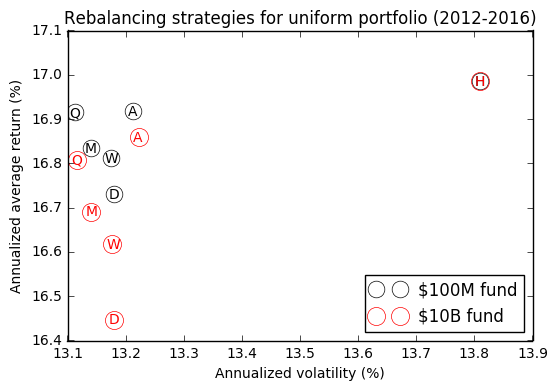

In [81]:
offsetx = 0.01
offsety = 0.01

colors=['k','r']
lines=[None,None]
for en,j in enumerate(res.columns):
    #plt.figure()
    for i in res.index:
        x = 100*res.loc[(i, j)].volatility 
        y = 100*res.loc[(i, j)].mean_return 
        line,=plt.plot(np.array(x),np.array(y), colors[en]+'o', markersize=12+en,
                  fillstyle='none', label='%s fund'%j)
        lines[en] = line
        plt.text(x-offsetx,y-offsety, i,color=colors[en] )


plt.legend(loc='lower right',handles=lines)
plt.xlabel('Annualized volatility (%)')
plt.ylabel('Annualized average return (%)')
plt.title("Rebalancing strategies for uniform portfolio (2012-2016)")
plt.xlim([13.1,13.9])
plt.ylim([16.4,17.1])
plt.savefig(plotdir+'basic_riskrewardfrontier.png')

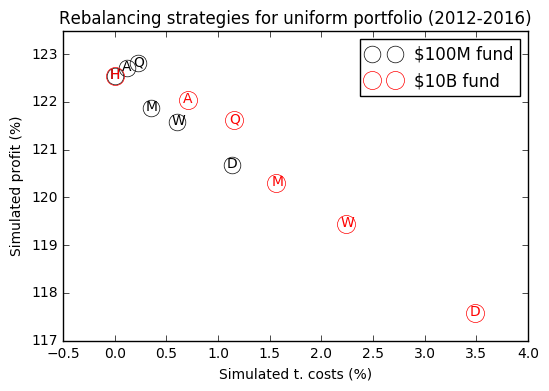

In [50]:
offsetx = 0.05
offsety = 0.06

for ticker, values in result_df.iterrows():
    for size, coord in values.unstack().iterrows():
        x,y=coord['TCosts'],coord['Profit']
        if size=='$100M':
            line1,=plt.plot(x,y, 'ko', markersize=12, fillstyle='none', label='\$100M fund')
            plt.text(x-offsetx,y-offsety, ticker)

        if size=='$10B':
            line2,=plt.plot(x,y, 'ro', markersize=13, fillstyle='none', label='\$10B fund')
            plt.text(x-offsetx,y-offsety,ticker,color='r' )

plt.xlim([-.5, 4])
plt.ylim([117,123.5])
plt.legend(loc='upper right',handles=[line1, line2])
plt.xlabel("Simulated t. costs (%)")
plt.ylabel("Simulated profit (%)")
plt.title("Rebalancing strategies for uniform portfolio (2012-2016)")

plt.savefig(plotdir+'pandl_vs_tcost.png')

In [ ]:
offsetx = 0.05
offsety = 0.06

for ticker, values in result_df.iterrows():
    for size, coord in values.unstack().iterrows():
        x,y=coord['TCosts'],coord['Profit']
        if size=='$100M':
            line1,=plt.plot(x,y, 'ko', markersize=12, fillstyle='none', label='\$100M fund')
            plt.text(x-offsetx,y-offsety, ticker)

        if size=='$10B':
            line2,=plt.plot(x,y, 'ro', markersize=13, fillstyle='none', label='\$10B fund')
            plt.text(x-offsetx,y-offsety,ticker,color='r' )

plt.xlim([-.5, 4])
plt.ylim([117,123.5])
plt.legend(loc='upper right',handles=[line1, line2])
plt.xlabel("Simulated t. costs (%)")
plt.ylabel("Simulated profit (%)")
plt.title("Rebalancing strategies for uniform portfolio (2012-2016)")

plt.savefig(plotdir+'return_vs_volatility.png')

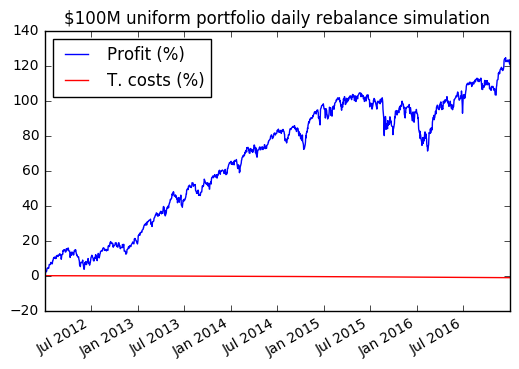

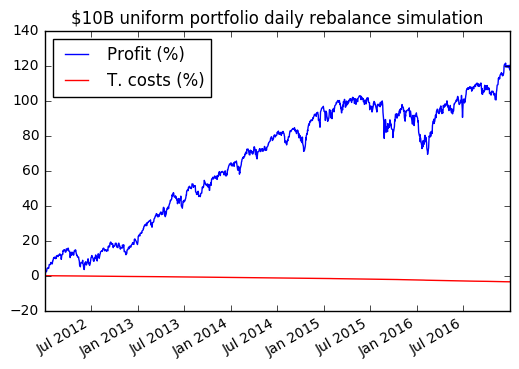

In [54]:
for k,results in res.loc['D'].iteritems():
    plt.figure()
    (100*(results.v-results.initial_val)/results.initial_val).plot(label='Profit (%)')
    (100*(-results.simulator_TcostModel.sum(1).cumsum())/results.initial_val).plot(style='r',label='T. costs (%)')
    plt.legend(loc='upper left')
    plt.title('%s uniform portfolio daily rebalance simulation'%k)
    plt.savefig(plotdir+'%s_pandl_tcost_tseries.png'%k[1:])